In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn 
import torch.optim as optim

import copy
import tqdm

import util
import os 

In [2]:
cwd = os.getcwd()
print(cwd)

/home/linhnm/msc_code/big_data_mining/eabdt/python


In [3]:
dataset = 'mix'

training_batch_from = 0
training_batch_to = 1500
val_batch_from = 3000
val_batch_to = 3600

testing_batch_from = 0
testing_batch_to = 400

In [4]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda:0'
  print('ok')

ok


In [5]:
X_train = util.load_vector(os.path.join(cwd, '../data/vectorize/mix/training_set'), training_batch_from, training_batch_to)
y_train = util.load_label(os.path.join(cwd, '../data/raw/mix/training_set'), training_batch_from, training_batch_to)

X_val = util.load_vector(os.path.join(cwd, '../data/vectorize/mix/training_set'), val_batch_from, val_batch_to)
y_val = util.load_label(os.path.join(cwd, '../data/raw/mix/training_set'), val_batch_from, val_batch_to)

X_test = util.load_vector(os.path.join(cwd, '../data/vectorize/mix/testing_set'), testing_batch_from, testing_batch_to)
y_test = util.load_label(os.path.join(cwd, '../data/raw/mix/testing_set'), testing_batch_from, testing_batch_to)

In [6]:
epochs = 10000
trigger = 500
early_stopping_round = 20

input_dim = 384
output_dim = 1
learning_rate = 0.01

In [7]:
class Softmax(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Softmax, self).__init__()
    # hidden layer 
    self.linear_one = torch.nn.Linear(input_dim, 64)
    self.linear_two = torch.nn.Linear(64, output_dim) 
    # defining layers as attributes
    self.layer_in = None
    self.act = None
    self.layer_out = None
  def forward(self, x):
    self.layer_in = self.linear_one(x)
    self.act = torch.sigmoid(self.layer_in)
    self.layer_out = self.linear_two(self.act)
    y_pred = torch.sigmoid(self.linear_two(self.act))
    return y_pred

In [8]:
model = Softmax(input_dim, output_dim)
model.to(device)

Softmax(
  (linear_one): Linear(in_features=384, out_features=64, bias=True)
  (linear_two): Linear(in_features=64, out_features=1, bias=True)
)

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
X_gpu_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_gpu_train = torch.flatten(torch.tensor(y_train).type(torch.float32)).to(device)
X_gpu_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_gpu_val = torch.flatten(torch.tensor(y_val).type(torch.float32)).to(device)
X_gpu_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_gpu_test = torch.flatten(torch.tensor(y_test).type(torch.float32)).to(device)

In [11]:
import time
losses = []
losses_val = []
acc_train = []
acc_val = []
Iterations = []
best_loss = torch.tensor(np.inf).to(device)
best_acc = 0
best_weights = None
iter = 0
early = 0
start = time.time()
for epoch in tqdm.tqdm(range(int(epochs)),desc='Training Epochs'):
    # start = time.time()
    x = X_gpu_train
    labels = y_gpu_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_gpu_train)
    loss = criterion(torch.squeeze(outputs), labels) 

    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

    optimizer.step() # Updates weights and biases with the optimizer (SGD)

    iter+=1
    early+=1
    if iter%trigger==0:
        early+=1
        with torch.no_grad():
            # Calculating the loss and accuracy for the val dataset
            correct_val = 0
            total_val = 0
            outputs_val = torch.squeeze(model(X_gpu_val))
            loss_val = criterion(outputs_val, y_gpu_val)
            
            # predicted_val = outputs_val.round()
            total_val += y_gpu_val.size(0)
            correct_val += torch.eq(outputs_val.round(), y_gpu_val).sum()
            accuracy_val = 100 * correct_val/total_val
            losses_val.append(loss_val.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_gpu_train.size(0)
            # correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_gpu_train.detach().numpy())
            correct += torch.eq(torch.squeeze(outputs).round(), y_gpu_train).sum()
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nval - Loss: {loss_val.item()}. Accuracy: {accuracy_val}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
            
            if accuracy_val > best_acc:
                best_weights = copy.deepcopy(model.state_dict())
            
            # if (early%early_stopping_round == 0) and (loss_val > torch.min(torch.tensor(losses_val[-4:-1]))):
            #     print(f'Early stopping, loss val: {loss_val}')
            #     break
            
end = time.time()
total_time = round(end - start, 3)


Training Epochs:   5%|▌         | 535/10000 [00:12<03:08, 50.34it/s]

Iteration: 500. 
val - Loss: 0.30707064270973206. Accuracy: 87.06600189208984
Train -  Loss: 0.30928945541381836. Accuracy: 86.92353057861328



Training Epochs:  10%|█         | 1035/10000 [00:25<02:58, 50.15it/s]

Iteration: 1000. 
val - Loss: 0.2761704623699188. Accuracy: 88.51782989501953
Train -  Loss: 0.27632492780685425. Accuracy: 88.51326751708984



Training Epochs:  15%|█▌        | 1535/10000 [00:37<02:48, 50.15it/s]

Iteration: 1500. 
val - Loss: 0.2667580842971802. Accuracy: 88.96099853515625
Train -  Loss: 0.26307639479637146. Accuracy: 89.16639709472656



Training Epochs:  20%|██        | 2035/10000 [00:49<02:39, 50.03it/s]

Iteration: 2000. 
val - Loss: 0.2616509795188904. Accuracy: 89.21849822998047
Train -  Loss: 0.2542162537574768. Accuracy: 89.57132720947266



Training Epochs:  25%|██▌       | 2535/10000 [01:01<02:30, 49.64it/s]

Iteration: 2500. 
val - Loss: 0.25942859053611755. Accuracy: 89.3066635131836
Train -  Loss: 0.2484610676765442. Accuracy: 89.810791015625



Training Epochs:  30%|███       | 3035/10000 [01:14<02:18, 50.32it/s]

Iteration: 3000. 
val - Loss: 0.2587560713291168. Accuracy: 89.33149719238281
Train -  Loss: 0.2445172220468521. Accuracy: 89.99353790283203



Training Epochs:  35%|███▌      | 3535/10000 [01:26<02:09, 49.81it/s]

Iteration: 3500. 
val - Loss: 0.25871825218200684. Accuracy: 89.32749938964844
Train -  Loss: 0.2421727031469345. Accuracy: 90.10353088378906



Training Epochs:  40%|████      | 4035/10000 [01:38<01:58, 50.25it/s]

Iteration: 4000. 
val - Loss: 0.2587558925151825. Accuracy: 89.33599853515625
Train -  Loss: 0.24069912731647491. Accuracy: 90.18506622314453



Training Epochs:  45%|████▌     | 4535/10000 [01:51<01:49, 50.13it/s]

Iteration: 4500. 
val - Loss: 0.25883930921554565. Accuracy: 89.35383605957031
Train -  Loss: 0.2396741658449173. Accuracy: 90.2316665649414



Training Epochs:  50%|█████     | 5034/10000 [02:03<01:38, 50.39it/s]

Iteration: 5000. 
val - Loss: 0.25890934467315674. Accuracy: 89.34749603271484
Train -  Loss: 0.23891253769397736. Accuracy: 90.27220153808594



Training Epochs:  55%|█████▌    | 5534/10000 [02:16<01:30, 49.12it/s]

Iteration: 5500. 
val - Loss: 0.258998304605484. Accuracy: 89.36133575439453
Train -  Loss: 0.23831991851329803. Accuracy: 90.29446411132812



Training Epochs:  60%|██████    | 6035/10000 [02:28<01:19, 49.98it/s]

Iteration: 6000. 
val - Loss: 0.2590787410736084. Accuracy: 89.36433410644531
Train -  Loss: 0.23783616721630096. Accuracy: 90.31913757324219



Training Epochs:  65%|██████▌   | 6535/10000 [02:41<01:09, 49.92it/s]

Iteration: 6500. 
val - Loss: 0.2591463029384613. Accuracy: 89.35050201416016
Train -  Loss: 0.23743529617786407. Accuracy: 90.33985900878906



Training Epochs:  70%|███████   | 7035/10000 [02:53<00:59, 49.59it/s]

Iteration: 7000. 
val - Loss: 0.25919896364212036. Accuracy: 89.3479995727539
Train -  Loss: 0.2370932549238205. Accuracy: 90.34773254394531



Training Epochs:  75%|███████▌  | 7535/10000 [03:05<00:49, 49.39it/s]

Iteration: 7500. 
val - Loss: 0.2592492401599884. Accuracy: 89.34300231933594
Train -  Loss: 0.23679617047309875. Accuracy: 90.35852813720703



Training Epochs:  80%|████████  | 8035/10000 [03:18<00:39, 50.06it/s]

Iteration: 8000. 
val - Loss: 0.25932735204696655. Accuracy: 89.3326644897461
Train -  Loss: 0.23655004799365997. Accuracy: 90.36993408203125



Training Epochs:  85%|████████▌ | 8535/10000 [03:30<00:29, 49.44it/s]

Iteration: 8500. 
val - Loss: 0.2593201994895935. Accuracy: 89.3326644897461
Train -  Loss: 0.23630467057228088. Accuracy: 90.38299560546875



Training Epochs:  90%|█████████ | 9035/10000 [03:43<00:19, 48.90it/s]

Iteration: 9000. 
val - Loss: 0.2593497931957245. Accuracy: 89.33966827392578
Train -  Loss: 0.23609808087348938. Accuracy: 90.39046478271484



Training Epochs:  95%|█████████▌| 9535/10000 [03:55<00:09, 49.32it/s]

Iteration: 9500. 
val - Loss: 0.25937676429748535. Accuracy: 89.33733367919922
Train -  Loss: 0.23591181635856628. Accuracy: 90.39973449707031



Training Epochs: 100%|██████████| 10000/10000 [04:08<00:00, 40.30it/s]

Iteration: 10000. 
val - Loss: 0.25940316915512085. Accuracy: 89.34966278076172
Train -  Loss: 0.23574185371398926. Accuracy: 90.4101333618164



In [12]:
time_str = "{:.3f}".format(total_time)
print(f'total training time: {time_str}')

total training time: 248.110


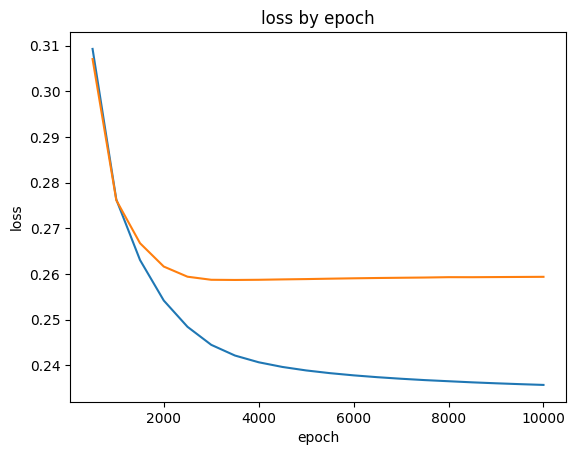

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Iterations, losses, color='tab:blue')
ax.plot(Iterations, losses_val, color='tab:orange')


plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss by epoch')
plt.show()

In [17]:
model.load_state_dict(best_weights)

correct_test = 0
total_test = 0
outputs_test = torch.squeeze(model(X_gpu_test))
loss_test = criterion(outputs_test, y_gpu_test)

total_test += y_gpu_test.size(0)
correct_test += torch.eq(outputs_test.round(), y_gpu_test).sum()
accuracy_test = 100 * correct_test/total_test

In [18]:
accuracy_test.item()

89.29824829101562

In [ ]:
model_path = '../model/torch_softmax'
torch.save(model.state_dict(), model_path)